**CIFAR-10 CNN**

Let's gather everything we need
- Clone the GitHub repo and set it as our working directory
- Install PyTorch and import the required packages

In [ ]:
!git clone https://github.com/benfogiel/CIFAR-10-CNN.git

Cloning into 'CIFAR-10-CNN'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 46 (delta 18), reused 14 (delta 5), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [ ]:
cd CIFAR-10-CNN/

/content/CIFAR-10-CNN


In [ ]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import test

In [ ]:
# checking if GPU is available or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# download CIFAR10 dataset
train_ds = datasets.CIFAR10("./data", train=True, download=True)
valid_ds = datasets.CIFAR10("./data", train=False)

170500096it [00:01, 91062295.43it/s]                                


Extracting ./data/cifar-10-python.tar.gz to ./data


Let's get familiar with the CIFAR-10 dataset. Here is a sample of first 16 samples in the dataset

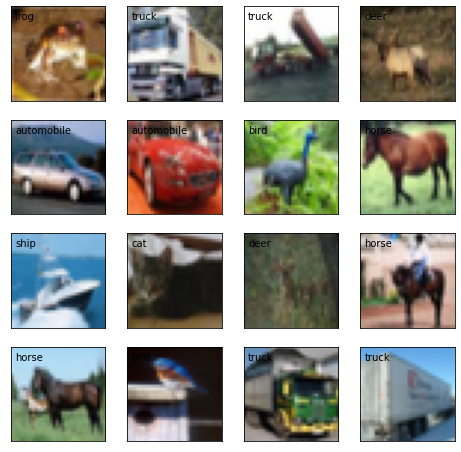

In [ ]:
# take the first 16 samples and visualize them in a grid
fig = plt.figure(figsize=(8, 8))
cls_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', \
            5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(train_ds[i][0])
    ax.text(1, 4, str(cls_dict[train_ds[i][1]]))
plt.show()

**Preparing the Dataset for Training**

In [ ]:
class TestData(datasets.VisionDataset):
    
    filepath = "./test.npy"
    
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data = np.load(self.filepath)
    
    def __getitem__(self, index: int):
        
        img = self.data[index]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img
        
    def __len__(self):
        return len(self.data)

test_ds = TestData("./data")

The CIFAR-10 images are in PIL format and we need them as tensors. To do this, we will use the PyTorch function ```torchvision.transforms``` of which will not only convert our images to tensors, but it will also normalize them



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_ds.transform = transform
valid_ds.transform = transform
test_ds.transform = transform

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_ds, batch_size=1000
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1000
)

Let's checkout the shape of one of our tensors

In [ ]:
train_ds[0][0].shape


torch.Size([3, 32, 32])

As you can see, we have 3 channels (representing RGB) and the pixel width and height of each image (32-by-32 pixels). Now that we have our data, let's build our CNN model

**Building our CNN Model**